# **Multivariate Architecture**

**Contains:** Multivariate architecture implementation for study and out-of-study models, with model training, evaluation, and visualization

## Setup

In [9]:
# Import modules

# STUDY
# Utilities
import os, sys
sys.path.append("../transformers/")
import warnings
warnings.simplefilter("ignore")

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model
from lineardetrender import LinearDetrender
from fftstack import FFTTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats

# Optimization
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

# Evaluation
from sklearn.metrics import r2_score, mean_squared_error

# OUT-OF-STUDY
from numpy.random import seed
seed(1)
from keras.models import Model
from attention import Attention
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Input
from sklearn.linear_model import LinearRegression

In [10]:
# Define convenience functions
def rmse(true, pred):
    return mean_squared_error(true, pred, squared=False)

def nrmse(true, pred):
    return mean_squared_error(true, pred, squared=False)/float(true.mean())

def yearly_linreg_p(true, pred):
    df = pd.concat((true, pred), axis=1).groupby(true.index.year)
    rmse_ = []
    for row in df:
        rmse_.append(rmse(row[1].iloc[:, 0], row[1].iloc[:, 1]))
    yearly_true_rmse = pd.Series(rmse_, index=list(true.index.year.drop_duplicates()))
    slope, intercept, r_value, p_value, std_err = stats.linregress(yearly_true_rmse.values, yearly_true_rmse.index)
    return p_value

def xy_split(train, test):
    train_x, train_y = train.iloc[:, 0:len(train.columns)-1], train.iloc[:, -1]
    test_x, test_y = test.iloc[:, 0:len(test.columns)-1], test.iloc[:, -1]
    return train_x, train_y, test_x, test_y

def in_range(start, end, step=1):
    return list(range(start, end+step, step))

def build_directory(directory):
    directory_array = list(filter(None, (f"/{directory}").split("/")[1:]))
    for i in range(1, len(directory_array) + 1):
        try:
            os.mkdir("/".join(directory_array[0:i]))
        except FileExistsError:
            pass

## Data

In [12]:
# Load original data

data_dir = "data/arctic-domain-mean-monthly.csv"
data = pd.read_csv(data_dir, index_col=0, parse_dates=True).asfreq("MS")

feature_names, target_name, col_names = data.columns[:-1], data.columns[-1], data.columns
len_train = 408
len_test = len(data)-len_train

train, test = data[:len_train], data[len_train:]
baseline_train_x, baseline_train_y, baseline_test_x, baseline_test_y = xy_split(train, test)

print(
    "train: ", len(train),
    "\ntest: ", len(test)
)

train:  408 
test:  104


## Architecture

In [14]:
# Detrend pipeline
detrend_pipe_x, detrend_pipe_y = (
    make_pipeline(
        LinearDetrender(p_thresh=0.05,
                        trend_freq="YS")
        ),
    make_pipeline(
        LinearDetrender(p_thresh=0.05,
                        trend_freq="YS")
        )
)

# FFT pipeline
fft_pipe_x, fft_pipe_y = (
    make_pipeline(
        LinearDetrender(
            p_thresh=0.05,
            trend_freq="YS"
            ),
        FFTTransformer(train_size=0.8,
                        iter_grid=np.arange(1,11),
                        threshold_grid=np.arange(0.05, 0.91, 0.05),
                        method="normalize",
                        performance_threshold=0.1
                        )
    ),
    make_pipeline(
        LinearDetrender(
            p_thresh=0.05,
            trend_freq="YS"
            ),
        FFTTransformer(train_size=0.8,
                        iter_grid=np.arange(1,11),
                        threshold_grid=np.arange(0.05, 0.91, 0.05),
                        method="normalize",
                        performance_threshold=0.1
                        )
    )
)

In [15]:
# Transform data

detrend_train_x, detrend_train_y, detrend_test_x, detrend_test_y = (
    detrend_pipe_x.fit_transform(baseline_train_x),
    detrend_pipe_y.fit_transform(pd.DataFrame(baseline_train_y)),
    detrend_pipe_x.transform(baseline_test_x),
    detrend_pipe_y.transform(pd.DataFrame(baseline_test_y))
    )

fft_train_x, fft_train_y, fft_test_x, fft_test_y = (
    fft_pipe_x.fit_transform(baseline_train_x),
    fft_pipe_y.fit_transform(pd.DataFrame(baseline_train_y)),
    fft_pipe_x.transform(baseline_test_x),
    fft_pipe_y.transform(pd.DataFrame(baseline_test_y))
    )

In [16]:
print("DETREND")
display(pd.concat([fft_pipe_x[0].results_, fft_pipe_y[0].results_]))

print("FFT")
display(pd.concat([fft_pipe_x[1].results_, fft_pipe_y[1].results_]))

DETREND


,variable,slope,intercept,r_value,p_value,rounded_p
0,wind_10m,0.000812,5.141560e+00,0.155110,3.810705e-01,0.38
1,specific_humidity,0.006092,2.210045e+00,0.756099,2.325314e-07,<0.001
2,LW_down,0.223986,2.377169e+02,0.781707,4.821095e-08,<0.001
3,SW_down,-0.015708,9.650255e+01,-0.202071,2.517692e-01,0.25
4,rainfall,0.001515,1.348264e+00,0.381012,2.620408e-02,0.03
5,snowfall,-0.001350,7.408220e-01,-0.450593,7.489022e-03,0.007
6,sst,0.026205,2.742361e+02,0.922446,8.998733e-15,<0.001
7,t2m,0.059496,2.636566e+02,0.817739,3.555040e-09,<0.001
8,surface_pressure,0.006463,9.811258e+02,0.056613,7.504725e-01,0.75
0,sea_ice_extent,-54961.344305,1.252700e+07,-0.928676,2.465856e-15,<0.001


FFT


,variable,iter,thresh,per_change,mad_avg,metric,res_percent_of_initial
0,wind_10m,4.0,0.75,-0.029808,0.083240,0.083240,0.269971
1,specific_humidity,2.0,0.10,0.078220,0.068969,0.068969,0.083597
2,LW_down,4.0,0.55,0.009140,1.903233,1.903233,0.043795
3,SW_down,2.0,0.05,-0.044461,0.685072,0.685072,0.009984
4,rainfall,2.0,0.10,0.057621,0.067835,0.067835,0.244662
5,snowfall,4.0,0.85,0.093828,0.047461,0.047461,0.257701
6,sst,1.0,0.05,0.076931,0.159369,0.159369,0.201613
7,t2m,2.0,0.10,0.078788,0.594313,0.594313,0.054891
8,surface_pressure,1.0,0.25,0.049375,1.574171,1.574171,0.786065
0,sea_ice_extent,2.0,0.25,0.080595,284681.194151,284681.194151,0.099539


## Models

In [ ]:
# Grid search forecasters

baseline_fcast = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(random_state=1),
    lags      = 1
)

detrend_fcast = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(random_state=1),
    lags      = 1
)

fft_fcast = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(random_state=1),
    lags      = 1
)

In [ ]:
# Parameter grids

lags_grid = in_range(12, 48, 12)

param_grid = {"n_estimators": in_range(25, 500, 25),
              "max_depth": in_range(1, 5, 1),
              "learning_rate": [1, 0.5, 0.1, 0.05, 0.01]}

build_directory("results/")

In [ ]:
# Baseline grid search
baseline_results = grid_search_forecaster(
    forecaster         = baseline_fcast,
    y                  = baseline_train_y,
    exog               = baseline_train_x,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = len(baseline_test_y),
    refit              = True,
    metric             = rmse,
    initial_train_size = int(len(baseline_train_y)*0.5),
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

results_dir = "results/baseline-grid-search-results.csv"
with open(results_dir, "w", encoding="utf-8-sig") as f:
    baseline_results.to_csv(f)

In [ ]:
# Detrend grid search
detrend_results = grid_search_forecaster(
    forecaster         = detrend_fcast,
    y                  = detrend_train_y[target_name],
    exog               = detrend_train_x,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = len(detrend_test_y),
    refit              = True,
    metric             = rmse,
    initial_train_size = int(len(detrend_train_y)*0.5),
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

results_dir = "results/detrend_results.csv"
with open(results_dir, "w", encoding="utf-8-sig") as f:
    detrend_results.to_csv(f)

In [ ]:
# FFT grid search
fft_results = grid_search_forecaster(
    forecaster         = fft_fcast,
    y                  = fft_train_y[target_name],
    exog               = fft_train_x,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = len(fft_test_y),
    refit              = True,
    metric             = rmse,
    initial_train_size = int(len(fft_train_y)*0.5),
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

results_dir = "results/fft_results.csv"
with open(results_dir, "w", encoding="utf-8-sig") as f:
    fft_results.to_csv(f)

In [7]:
# Best models

baseline_best_params = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 325}
baseline_best_lag = 36
baseline_best_fcast = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(random_state=1, **baseline_best_params),
    lags      = baseline_best_lag
)
baseline_best_fcast.fit(exog=baseline_train_x, y=baseline_train_y)
baseline_pred = baseline_best_fcast.predict(exog=baseline_test_x, steps=len(baseline_test_y))

detrend_best_params = {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 275}
detrend_best_lag = 12
detrend_best_fcast = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(random_state=1, **detrend_best_params),
    lags      = detrend_best_lag
)
detrend_best_fcast.fit(exog=detrend_train_x, y=detrend_train_y[target_name])
detrend_pred = detrend_best_fcast.predict(exog=detrend_test_x, steps=len(detrend_test_y))

fft_best_params = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 175}
fft_best_lag = 12
fft_best_fcast = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(random_state=1, **fft_best_params),
    lags      = fft_best_lag
)
fft_best_fcast.fit(exog=fft_train_x, y=fft_train_y[target_name])
fft_pred = fft_best_fcast.predict(exog=fft_test_x, steps=len(fft_test_y))

## Integrated Models
Integrates detrending and rFFT with models from existing research

### Data

In [8]:
def reshape_features(dataset, timesteps=1):
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

lag = 1
timesteps = 1

In [21]:
baseline_scaler_x_, baseline_scaler_y_ = StandardScaler(), StandardScaler()
baseline_train_x_, baseline_train_y_, baseline_test_x_, baseline_test_y_ = (
    np.array(baseline_train_x).reshape(-1, 1, 9)[:-lag, :],
    np.array(baseline_train_y).reshape(-1)[lag:],
    np.array(baseline_test_x).reshape(-1, 1, 9)[:-lag, :],
    np.array(baseline_test_y).reshape(-1)[lag:]
    )
baseline_train_x_, baseline_train_y_, baseline_test_x_, baseline_test_y_ = (
    reshape_features(baseline_scaler_x_.fit_transform(baseline_train_x_.reshape(-1,9)), timesteps),
    baseline_scaler_y_.fit_transform(baseline_train_y_.reshape(-1,1)),
    reshape_features(baseline_scaler_x_.transform(baseline_test_x_.reshape(-1,9)), timesteps),
    baseline_scaler_y_.transform(baseline_test_y_.reshape(-1,1))
)

detrend_scaler_x_, detrend_scaler_y_ = StandardScaler(), StandardScaler()
detrend_train_x_, detrend_train_y_, detrend_test_x_, detrend_test_y_ = (
    np.array(detrend_train_x).reshape(-1, 1, 9)[:-lag, :],
    np.array(detrend_train_y).reshape(-1)[lag:],
    np.array(detrend_test_x).reshape(-1, 1, 9)[:-lag, :],
    np.array(detrend_test_y).reshape(-1)[lag:]
    )
detrend_train_x_, detrend_train_y_, detrend_test_x_, detrend_test_y_ = (
    reshape_features(detrend_scaler_x_.fit_transform(detrend_train_x_.reshape(-1,9)), timesteps),
    detrend_scaler_y_.fit_transform(detrend_train_y_.reshape(-1,1)),
    reshape_features(detrend_scaler_x_.transform(detrend_test_x_.reshape(-1,9)), timesteps),
    detrend_scaler_y_.transform(detrend_test_y_.reshape(-1,1))
)

fft_scaler_x_, fft_scaler_y_ = StandardScaler(), StandardScaler()
fft_train_x_, fft_train_y_, fft_test_x_, fft_test_y_ = (
    np.array(fft_train_x).reshape(-1, 1, 9)[:-lag, :],
    np.array(fft_train_y).reshape(-1)[lag:],
    np.array(fft_test_x).reshape(-1, 1, 9)[:-lag, :],
    np.array(fft_test_y).reshape(-1)[lag:]
    )
fft_train_x_, fft_train_y_, fft_test_x_, fft_test_y_ = (
    reshape_features(fft_scaler_x_.fit_transform(fft_train_x_.reshape(-1,9)), timesteps),
    fft_scaler_y_.fit_transform(fft_train_y_.reshape(-1,1)),
    reshape_features(fft_scaler_x_.transform(fft_test_x_.reshape(-1,9)), timesteps),
    fft_scaler_y_.transform(fft_test_y_.reshape(-1,1))
)

### Sea Ice Forecasting using Attention-based Ensemble LSTM
Adapted from Ali et al. [\[1\]](#Sources)

In [17]:
model_input = Input(shape=(timesteps, len(feature_names)))
x = LSTM(64, return_sequences=True)(model_input)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)
x = Attention(trainable = True)(x)
x = Dropout(0.2)(x)
x = Dense(32)(x)
x = Dense(16)(x)
x = Dense(1)(x)
model = Model(model_input, x)

model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
model.fit(baseline_train_x_, baseline_train_y_, epochs=500, batch_size=12, verbose=0, validation_split=0.3, shuffle=True, callbacks=keras_callbacks)
attention_baseline_pred = model.predict(x=baseline_test_x_)

model.fit(detrend_train_x_, detrend_train_y_, epochs=500, batch_size=12, verbose=0, validation_split=0.3, shuffle=True, callbacks=keras_callbacks)
attention_detrend_pred = model.predict(x=detrend_test_x_)

model.fit(fft_train_x_, fft_train_y_, epochs=5, batch_size=12, verbose=0, validation_split=0.3, shuffle=True, callbacks=keras_callbacks)
attention_fft_pred = model.predict(x=fft_test_x_)

4/4 [==============================] - 0s 3ms/step


### Benchmarking Probabilistic Machine Learning Models for Arctic Sea Ice Forecasting
Adapted from Ali et al. [\[2\]](#Sources)

In [22]:
model = LinearRegression()

model.fit(baseline_train_x_.reshape(len_train-1, len(feature_names)), baseline_train_y_)
benchmarking_baseline_pred = model.predict(X=baseline_test_x_.reshape(len_test-1, len(feature_names)))

model.fit(detrend_train_x_.reshape(len_train-1, len(feature_names)), detrend_train_y_)
benchmarking_detrend_pred = model.predict(X=detrend_test_x_.reshape(len_test-1, len(feature_names)))

model.fit(fft_train_x_.reshape(len_train-1, len(feature_names)), fft_train_y_)
benchmarking_fft_pred = model.predict(X=fft_test_x_.reshape(len_test-1, len(feature_names)))

## Predictions

In [ ]:
# Final predictions

cycles_final = fft_pipe_y.inverse_transform(pd.DataFrame(0, index=test.index, columns=[target_name]))

detrend_final = detrend_pipe_y.inverse_transform(detrend_pred.to_frame(name=target_name))

fft_final = fft_pipe_y.inverse_transform(fft_pred.to_frame(name=target_name))

baseline_test_y_inv = pd.Series(baseline_scaler_y_.inverse_transform(baseline_test_y_).reshape(-1), index=test[:-1].index).to_frame(name=target_name)

attention_baseline_final = pd.Series(baseline_scaler_y_.inverse_transform(attention_baseline_pred).reshape(-1), index=test[:-1].index).to_frame(name=target_name)

attention_detrend_final = detrend_pipe_y.inverse_transform(pd.Series(detrend_scaler_y_.inverse_transform(attention_detrend_pred).reshape(-1), index=test[:-1].index).to_frame(name=target_name))

attention_fft_final = fft_pipe_y.inverse_transform(pd.Series(fft_scaler_y_.inverse_transform(attention_fft_pred).reshape(-1), index=test[:-1].index).to_frame(name=target_name))

benchmarking_baseline_final = pd.Series(baseline_scaler_y_.inverse_transform(benchmarking_baseline_pred).reshape(-1), index=test[:-1].index).to_frame(name=target_name)

benchmarking_detrend_final = detrend_pipe_y.inverse_transform(pd.Series(detrend_scaler_y_.inverse_transform(benchmarking_detrend_pred).reshape(-1), index=test[:-1].index).to_frame(name=target_name))

benchmarking_fft_final = fft_pipe_y.inverse_transform(pd.Series(fft_scaler_y_.inverse_transform(benchmarking_fft_pred).reshape(-1), index=test[:-1].index).to_frame(name=target_name))


## Evaluation

In [ ]:
class EvaluationTable:
    def __init__(self, metrics, index_col="model"):
        self.metric_names = metrics.keys()
        self.metric_funcs = metrics.values()
        self.table = pd.DataFrame(columns=self.metric_names)

    def addEvaluation(self, name, true, pred):
        metric_results = []
        for metric in self.metric_funcs:
            metric_results.append(metric(true, pred))
        self.table.loc[name] = metric_results

    def loadTable(self):
        return self.table

In [24]:
# gbr predictions and existing model predictions on various data inputs 

metrics = {"rmse": rmse,
           "nrmse": nrmse,
           "r_squared": r2_score}

ml_dl_eval = EvaluationTable(metrics)

ml_dl_eval.addEvaluation("study_baseline", baseline_test_y, baseline_pred)
ml_dl_eval.addEvaluation("study_detrend", detrend_test_y, detrend_pred)
ml_dl_eval.addEvaluation("study_fft", fft_test_y, fft_pred)
ml_dl_eval.addEvaluation("attention_baseline", baseline_test_y_, attention_baseline_pred)
ml_dl_eval.addEvaluation("attention_detrend", detrend_test_y_, attention_detrend_pred)
ml_dl_eval.addEvaluation("attention_fft", fft_test_y_, attention_fft_pred)
ml_dl_eval.addEvaluation("bnchmkng_baseline", baseline_test_y_, benchmarking_baseline_pred)
ml_dl_eval.addEvaluation("bnchmkng_detrend", detrend_test_y_, benchmarking_detrend_pred)
ml_dl_eval.addEvaluation("bnchmkng_fft", fft_test_y_, benchmarking_fft_pred)

build_directory("results/predictions")
results_table = ml_dl_eval.loadTable()
results_table.to_csv("results/predictions/ml-dl-evaluation.csv")
results_table

file exists
file exists


,rmse,nrmse,r_squared
study_baseline,637720.767868,0.060440,0.965131
study_detrend,475498.915534,2.025019,0.980496
study_fft,298025.108212,1.922003,0.609660
attention_baseline,0.225605,-0.654705,0.956387
attention_detrend,0.118227,1.721371,0.988379
attention_fft,0.659425,1.966009,0.600039
bnchmkng_baseline,0.143262,-0.415747,0.982414
bnchmkng_detrend,0.104529,1.521930,0.990916
bnchmkng_fft,0.687842,2.050730,0.564825


In [25]:
metrics = {"rmse": rmse,
           "nrmse": nrmse,
           "r_squared": r2_score,
           "yearly_linreg_p": yearly_linreg_p}

final_eval = EvaluationTable(metrics)
final_eval.addEvaluation("fftstack-cycles", baseline_test_y, cycles_final.iloc[:,0])
final_eval.addEvaluation("study-baseline", baseline_test_y, baseline_pred)
final_eval.addEvaluation("study-detrend", baseline_test_y, detrend_final)
final_eval.addEvaluation("study-fft", baseline_test_y, fft_final)
fft_test_y_inv = fft_pipe_y.inverse_transform(pd.Series(fft_scaler_y_.inverse_transform(baseline_test_y_).reshape(-1), index=test[:-1].index).to_frame(name=target_name))
final_eval.addEvaluation("attention-baseline", baseline_test_y_inv, attention_baseline_final)
final_eval.addEvaluation("attention-detrend", baseline_test_y_inv, attention_detrend_final)
final_eval.addEvaluation("attention-fft", fft_test_y_inv, attention_fft_final)
final_eval.addEvaluation("bnchmkng-baseline", baseline_test_y_inv, benchmarking_baseline_final.iloc[:,0])
final_eval.addEvaluation("bnchmkng-detrend", baseline_test_y_inv, benchmarking_detrend_final)
final_eval.addEvaluation("bnchmkng-fft", fft_test_y_inv, benchmarking_fft_final)

build_directory("results/predictions")
results_table = final_eval.loadTable()
results_table.to_csv("results/predictions/final-evaluation.csv")
results_table

,rmse,nrmse,r_squared,yearly_linreg_p
fftstack-cycles,501583.268831,0.047537,0.978429,0.136653
study-baseline,637720.767868,0.060440,0.965131,0.015104
study-detrend,475498.915534,0.045065,0.980614,0.489337
study-fft,298025.108212,0.028245,0.992385,0.289459
attention-baseline,713690.990622,0.067836,0.956387,0.025964
attention-detrend,366854.015056,0.034870,0.988477,0.008178
attention-fft,374170.774243,0.036381,0.988520,0.643330
bnchmkng-baseline,453203.405480,0.043077,0.982414,0.062588
bnchmkng-detrend,323423.196265,0.030741,0.991044,0.077528
bnchmkng-fft,355783.432611,0.034593,0.989621,0.716246


## Visualization

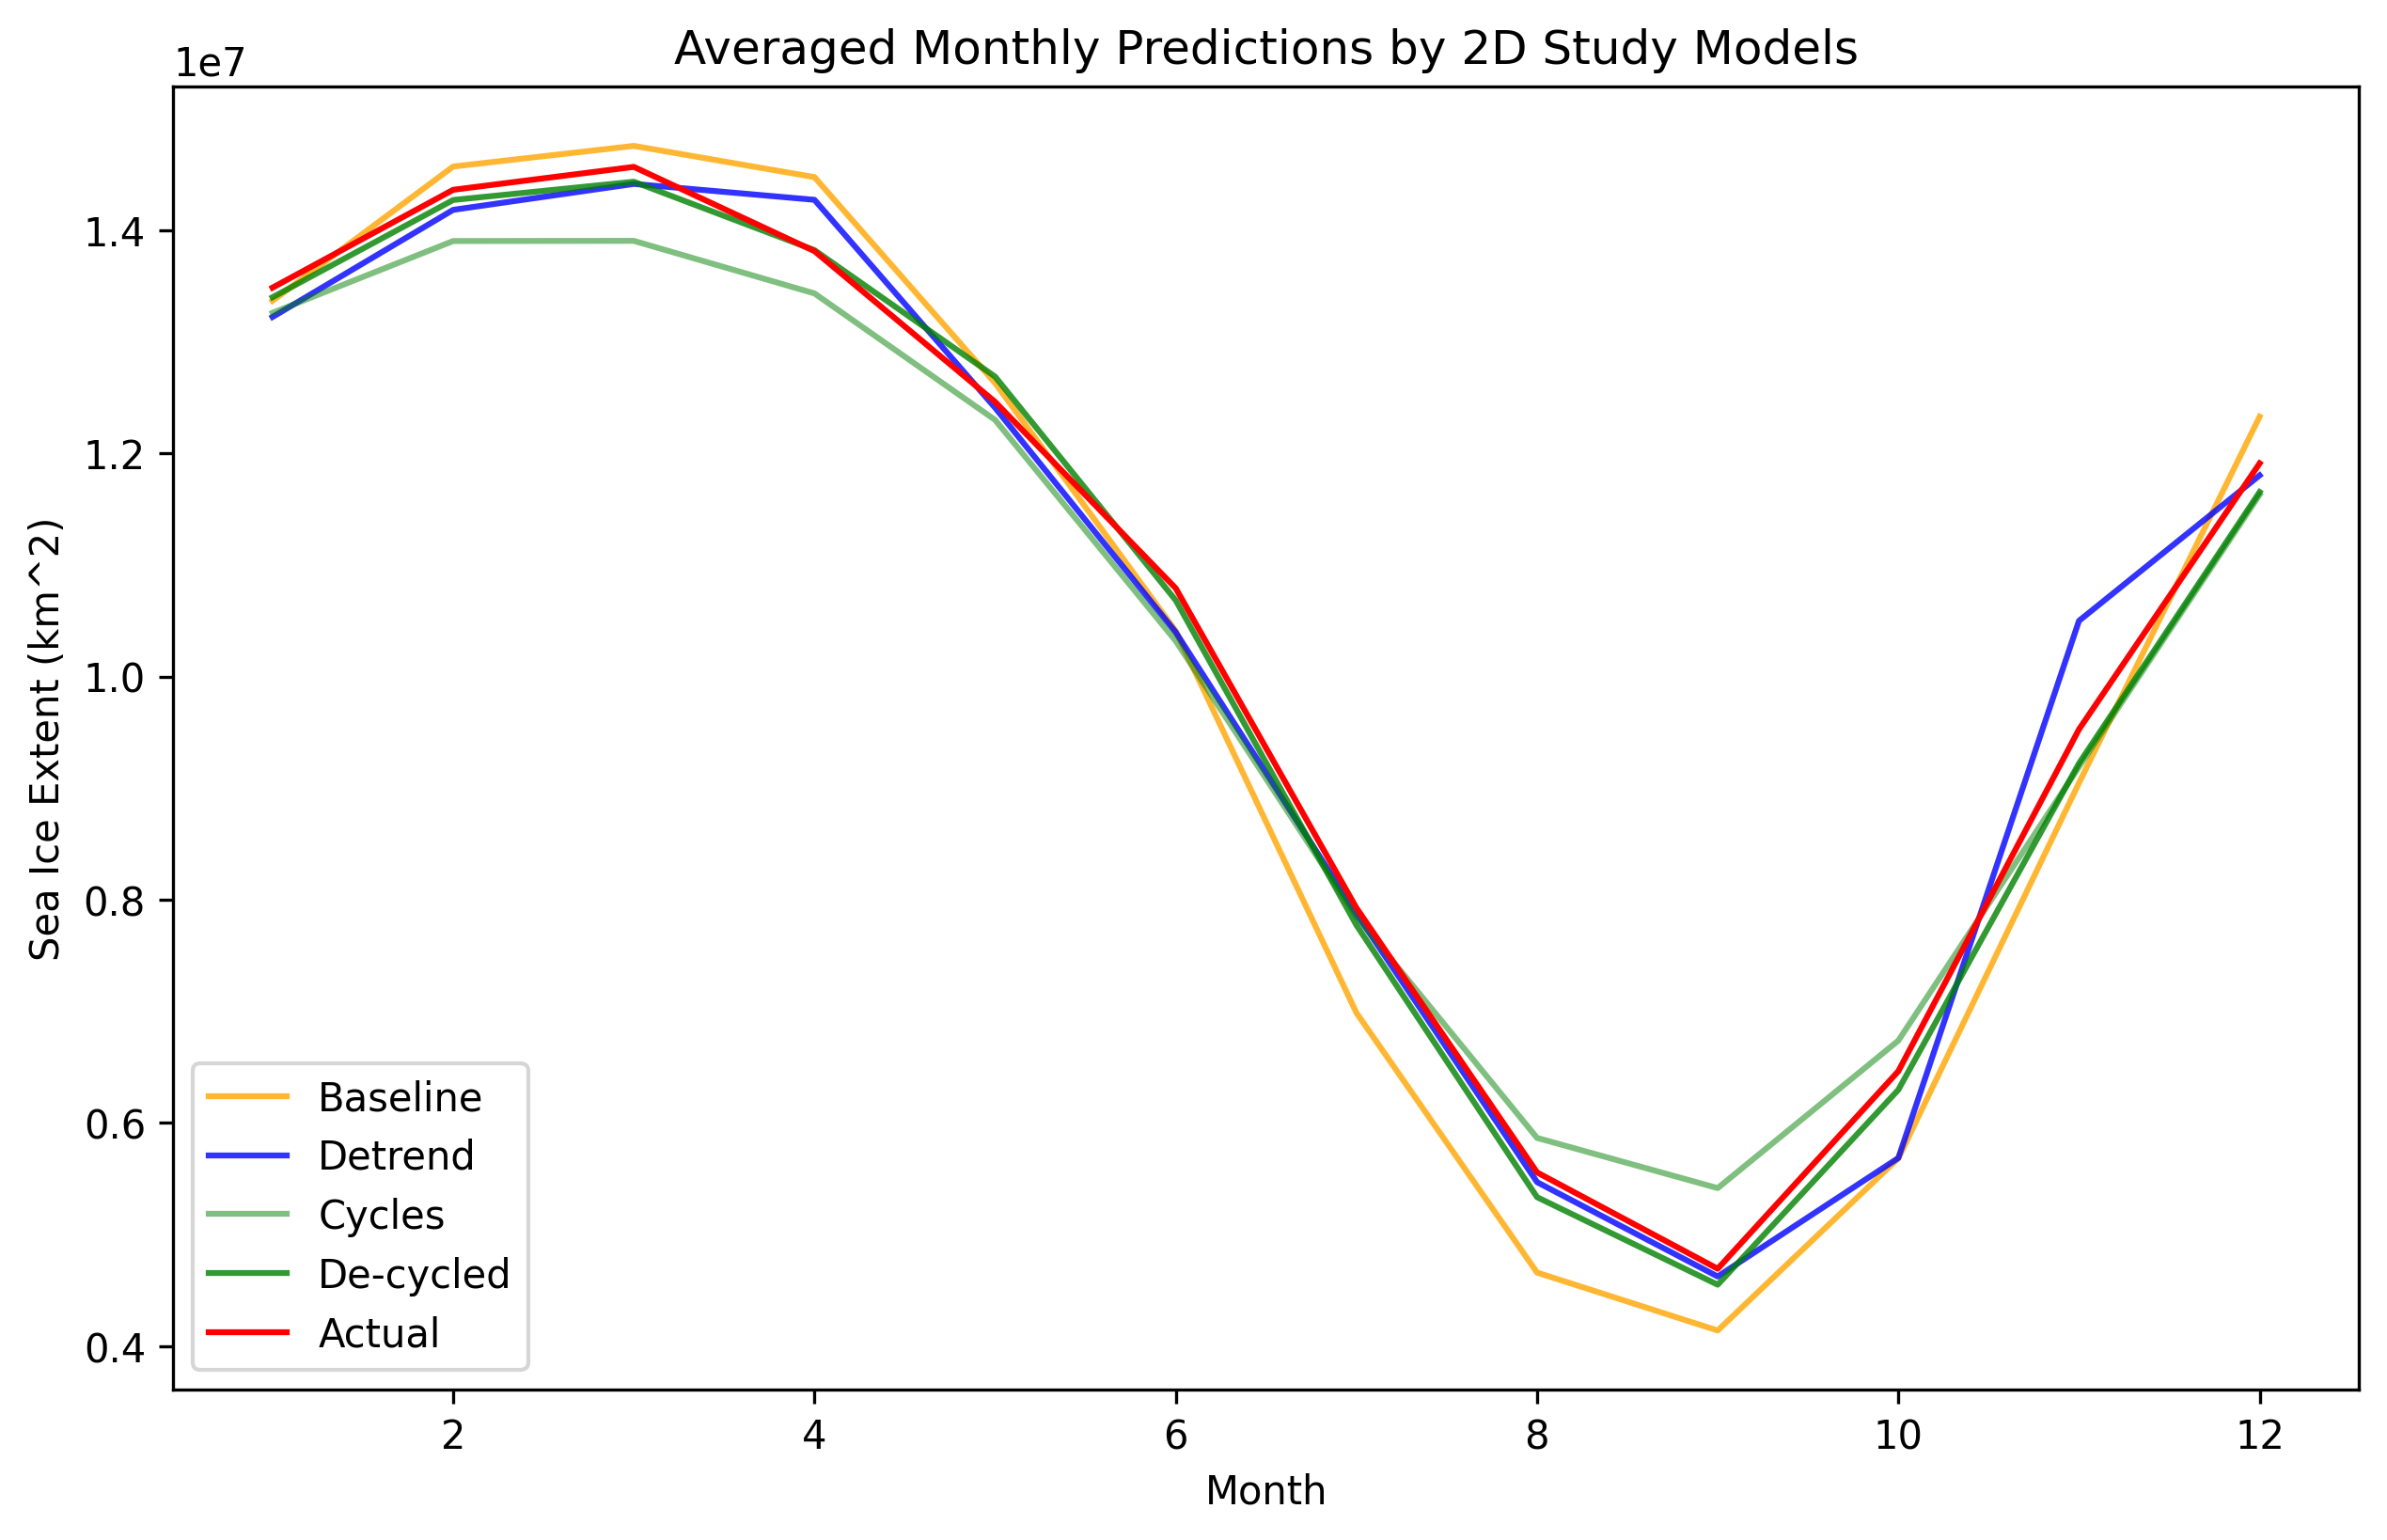

In [ ]:
group_by = baseline_pred.index.month
actual_by_month = baseline_test_y.groupby(group_by).mean()
baseline_by_month = baseline_pred.groupby(group_by).mean()
detrend_by_month = detrend_final.groupby(group_by).mean()
cycles_by_month = cycles_final.groupby(group_by).mean()
fft_by_month = fft_final.groupby(group_by).mean()

plt.close("all")
plt.figure(figsize=(10,6))
plt.plot(baseline_by_month, alpha=0.8, color="orange", label="Baseline")
plt.plot(detrend_by_month, alpha=0.8, color="blue", label="Detrend")
plt.plot(cycles_by_month, alpha=0.5, color="green", label="Cycles")
plt.plot(fft_by_month, alpha=0.8, color="green", label="De-cycled")
plt.plot(actual_by_month, color="red", label="Actual")
plt.xlabel("Month")
plt.ylabel("Sea Ice Extent (km^2)")
plt.title("Averaged Monthly Predictions by 2D Study Models")
plt.legend(loc="lower left")
plt.show()

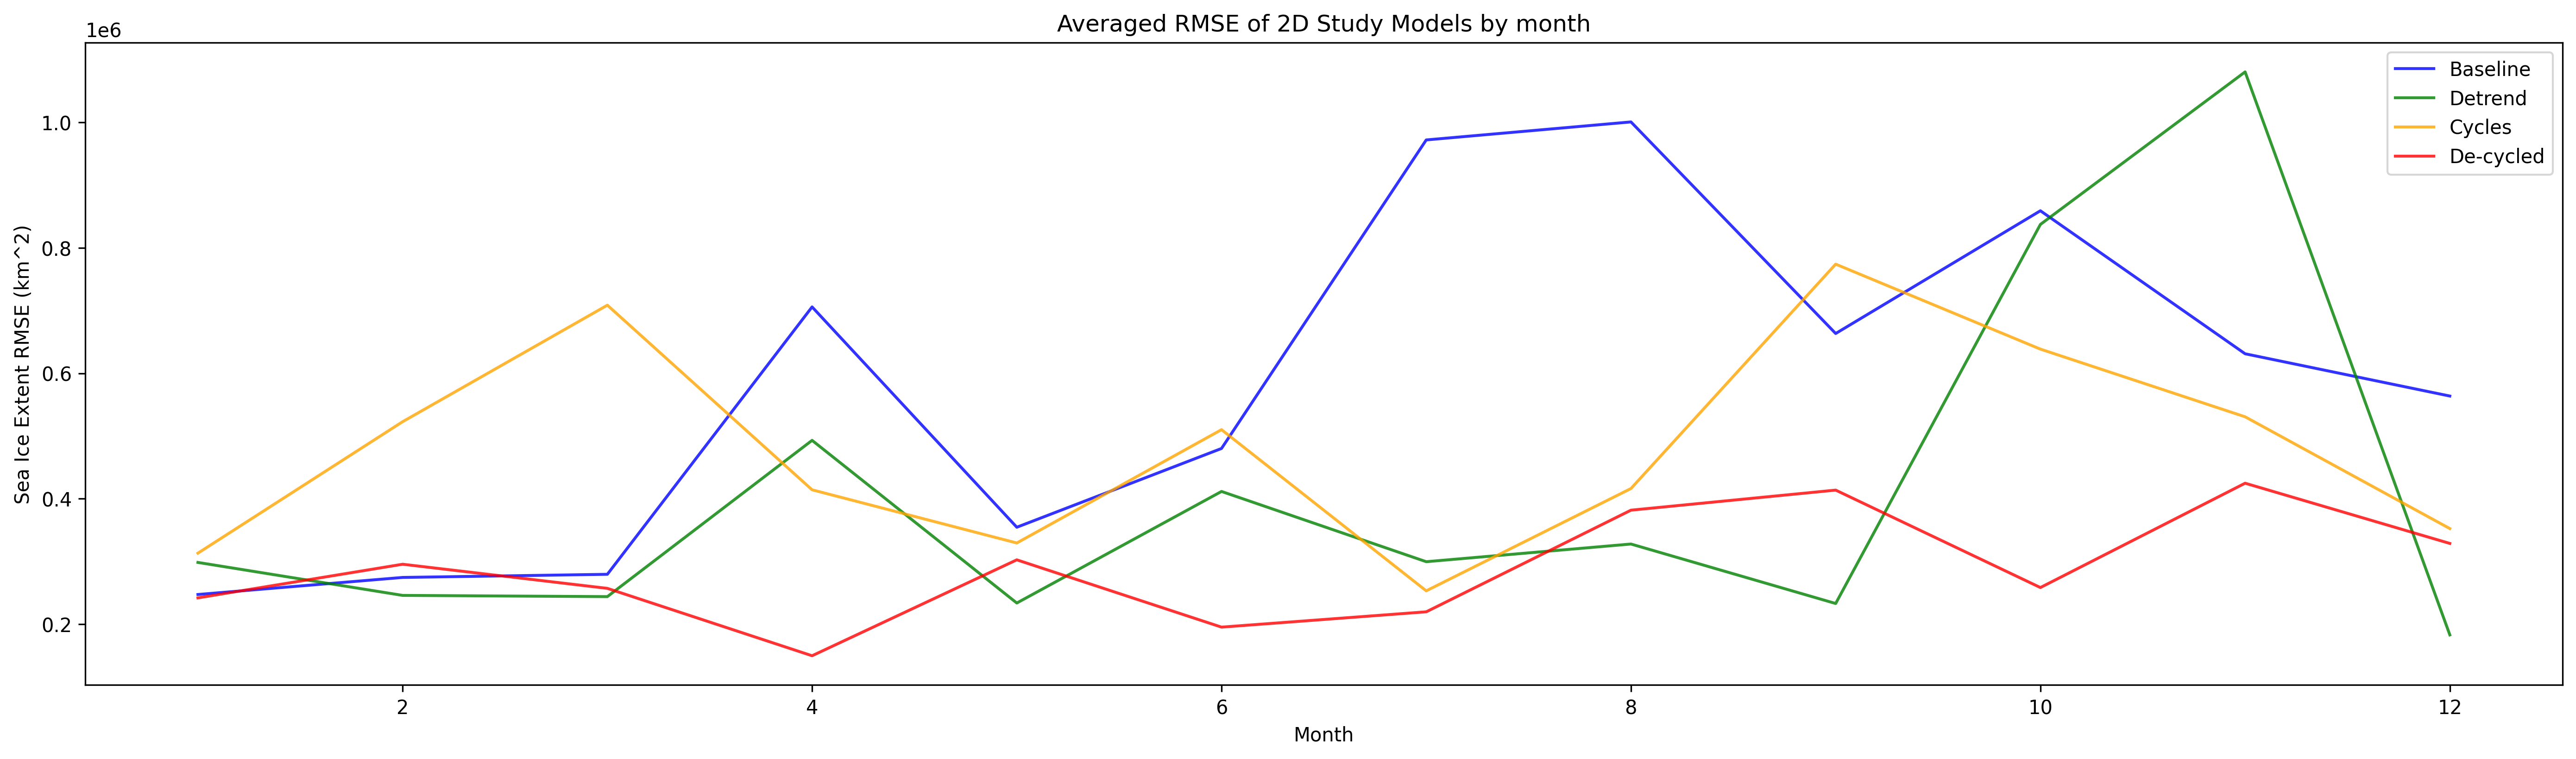

In [ ]:
def rowwise_rmse(df1, df2):
  df = pd.concat((df1, df2), axis=1).groupby(df1.index.month)
  rmse_ = []
  for row in df:
    rmse_.append(rmse(row[1].iloc[:, 0], row[1].iloc[:, 1]))
  return pd.Series(rmse_, index=list(df1.index.month.drop_duplicates()))

baseline_rmse_alltime = rowwise_rmse(baseline_test_y, baseline_pred)
detrend_rmse_alltime = rowwise_rmse(baseline_test_y, detrend_final)
cycles_rmse_alltime = rowwise_rmse(baseline_test_y, cycles_final)
fft_rmse_alltime = rowwise_rmse(baseline_test_y, fft_final)

plt.close("all")
plt.figure(figsize=(23,6))
plt.plot(baseline_rmse_alltime, alpha=0.8, label="Baseline", color="blue")
plt.plot(detrend_rmse_alltime, alpha=0.8, label="Detrend", color="green")
plt.plot(cycles_rmse_alltime, alpha=0.8, label="Cycles", color="orange")
plt.plot(fft_rmse_alltime, alpha=0.8, label="De-cycled", color="red")
plt.xlabel("Month")
plt.ylabel("Sea Ice Extent RMSE (km^2)")
plt.title("Averaged RMSE of 2D Study Models by month")
plt.legend()
plt.show()

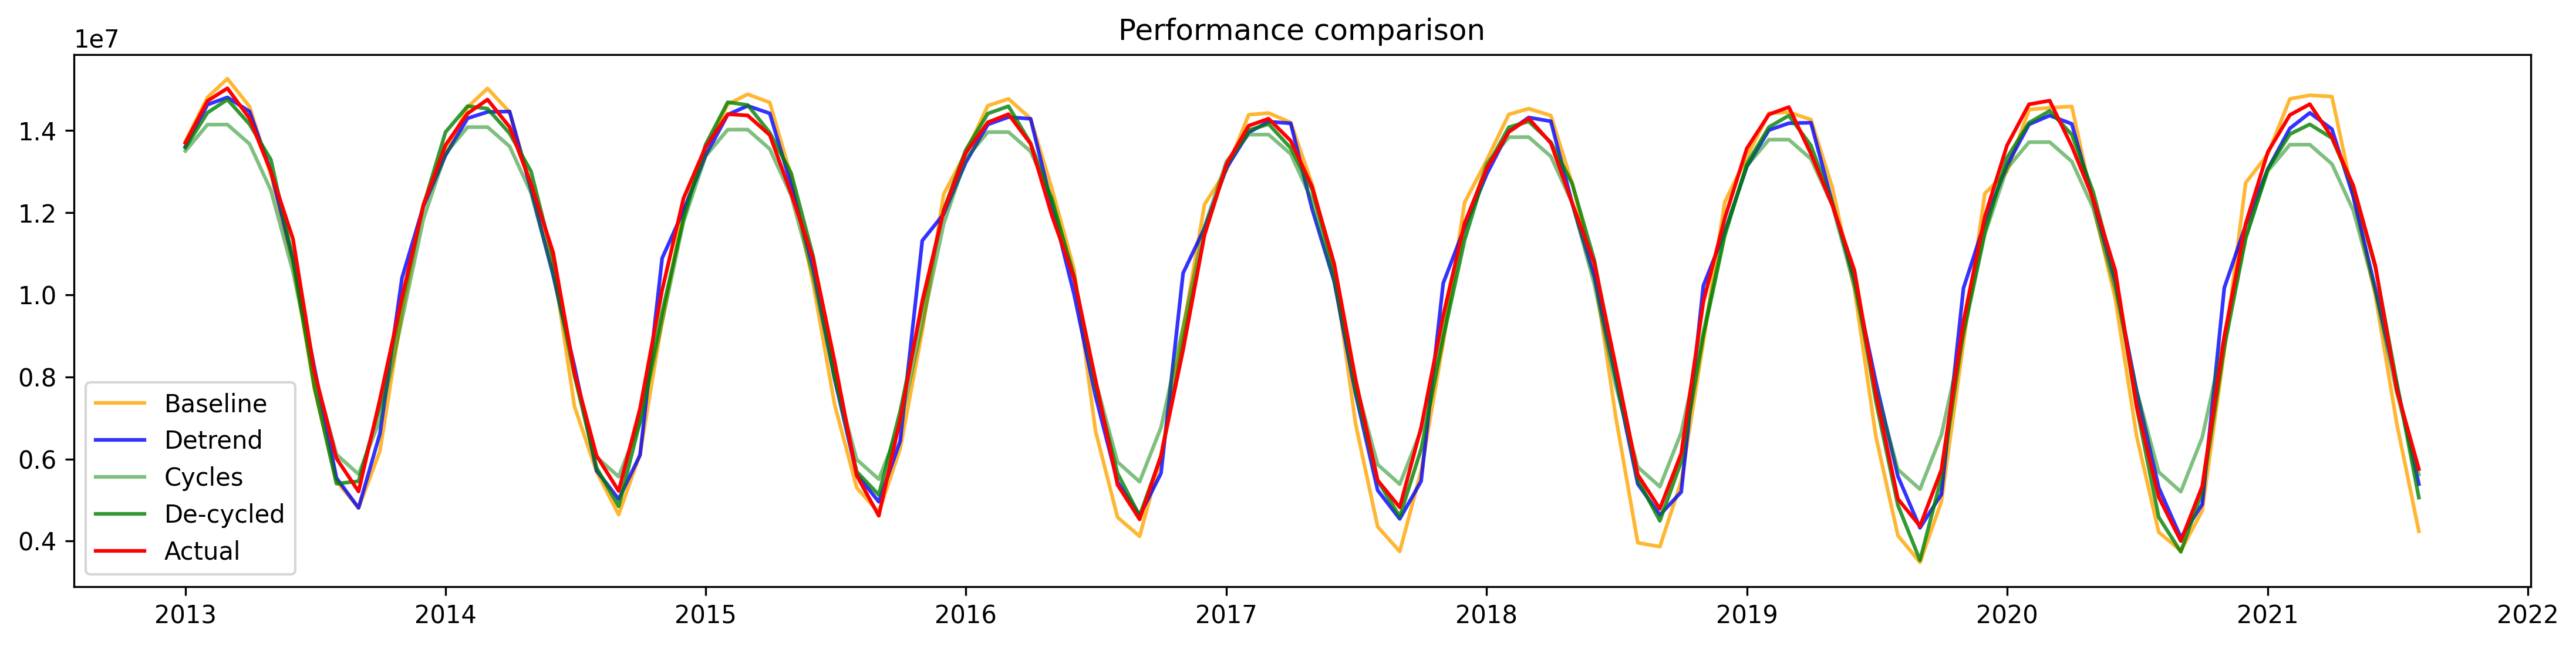

In [ ]:
plt.close("all")
plt.figure(figsize=(18,4))
plt.plot(baseline_pred, alpha=0.8, color="orange", label="Baseline")
plt.plot(detrend_final, alpha=0.8, color="blue", label="Detrend")
plt.plot(cycles_final, alpha=0.5, color="green", label="Cycles")
plt.plot(fft_final, alpha=0.8, color="green", label="De-cycled")
plt.plot(baseline_test_y, color="red", label="Observations")
plt.title("Performance comparison")
plt.legend()
plt.show()